In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

base_dir = os.getcwd() 
#try hough lines?

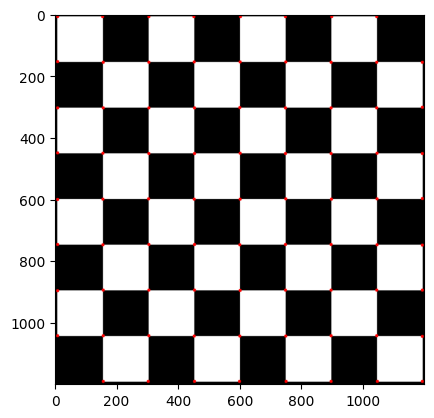

In [ ]:
img = cv2.imread(os.path.join(base_dir,"data/test", "chessboard.png")) ##line segement detection a la boreholes
(h,w)=img.shape[:2]
aspect_ratio = h / w
img = cv2.resize(img, (w,h), fx= 0.75, fy= 0.75)

## feature detection on grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

##corner detactor
corners = cv2.goodFeaturesToTrack(gray_img,100,0.01,10) #img, n of best corners to return, min quality of corner [0-1],min ed btw cornerers allowed
croners= np.int32(corners) #floating points to integers
for corner in corners:
    x,y= corner.ravel() #flatten
    cv2.circle(img,(int(x),int(y)),5,(255,0,0),-1)#img, coordinate, size, color, fill

cv2.imshow("img",img) 

cv2.waitKey(6000)
cv2.destroyAllWindows()
plt.imshow(img)
plt.show()